# Convolutional Neural Network - OLD


### Import Packages


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

# Check If GPU Enabled
Latest functioning version set as of October 6, 2024 according to https://www.tensorflow.org/install/source_windows is
- Python 3.10.11
- Tensorflow 2.10
- CUDA Toolkit 11.2
- CUDNN 8.1

In [3]:
# tf.debugging.set_log_device_placement(True) # For Verbose Output
print("Version: ", tf.__version__)


print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))


gpus = tf.config.list_physical_devices("GPU")
if gpus:

    print("TensorFlow is using GPU")
    for gpu in gpus:

        print(gpu.name)
else:

    print("TensorFlow is not using GPU")

Version:  2.17.0
Num GPUs Available:  []
TensorFlow is not using GPU


# Checkpoint and Save Data


In [8]:
# checkpoint_path = r"./checkpoints/tf.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath="./checkpoints/tf.keras", verbose=1
# )

# Pick Datasets to Train


In [9]:
lunar_train_dir = r"../../data/lunar/training/data/S12_GradeA"
num_of_events = len(
    [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
)
print("Number of events: ", num_of_events)
event = [i for i in range(1)]

Number of events:  76


# Import Catalog


In [10]:
catalog_path = r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_path)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


# Get Filename and Anomaly Position

In [11]:
event_filename = [catalog["filename"][i] + r".csv" for i in event]
print(event_filename)

true_anomaly_time = [int(catalog["time_rel(sec)"][i]) for i in event]
print(true_anomaly_time)

['xa.s12.00.mhz.1970-01-19HR00_evid00002.csv']
[73500]


## Load Lunar Training Data


In [12]:
csv_files_path = r"../../data/lunar/training/data/S12_GradeA"
csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
print(csv_files)

['../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-01-19HR00_evid00002.csv']


# Get Length, Time, and Speed of Each Event
Load all .csv's into one dataframe. Additionally, take the standard normal value of the velocity values, *i.e.*
$$
    X_{standard} = \frac{X - \mu_X}{\sigma_X}.
$$

In [14]:
lens_array = []
time_arrays = []
data_arrays = []
for file in csv_files:
    df = pd.read_csv(file)

    lens_array.append(len(df))

    t = df["time_rel(sec)"].values
    time_arrays.append(t)

    X = df["velocity(m/s)"].values
    X_standard = (X - np.mean(X)) / np.std(X)
    data_arrays.append(X_standard)


time_array = np.concatenate(time_arrays)
time = pd.DataFrame(time_array, columns=["time_rel(sec)"])

data_array = np.concatenate(data_arrays)
seismic_data = pd.DataFrame(data_array, columns=["velocity(m/s)"])

## Data Preparation

In [15]:
X_standard = seismic_data["velocity(m/s)"].values
X_standard = X_standard.astype(np.float32)  # To save memory

# Create Window Sequences

In [ ]:
windows_size = 16
batch_size = 500

# Create sequences for CNN
windows = []
for i in range(len(X_standard) - windows_size):
    windows.append(X_standard[i : i + windows_size])

windows = np.array(windows)

In [16]:
print(windows.shape)

(572399, 16)


# Get True Anomaly Labels

Places a 1 in `y` for the values `y[anomaly_position - 20, anomaly_position + 20]`.

In [23]:
width = 20
freq = 6.625
sampling_freq = 1 / freq

y = np.zeros(len(X_standard[windows_size:]))

for anomaly_index in range(len(true_anomaly_time)):

    length = lens_array[anomaly_index]
    start = np.sum(lens_array[j] for j in range(anomaly_index))
    end = start + length
    print("Length of event:", length)
    print("[Start, End]:", "[", start, ",", end, "]")

    anomaly = true_anomaly_time[anomaly_index]
    print("Anomaly position:", anomaly)

    sigma = int(width)
    center = int(anomaly * freq)
    y[start + center - sigma : start + center + sigma] = 1
    print("Range of 1s:", "[", start + center - sigma, ",", start + center + sigma, "]")
    print("===================")

print("===================")
print("y shape:", y.shape)
print("Non-zero elements in y:", np.count_nonzero(y))

(572415,)
Length of event: 572415
[Start, End]: [ 0 , 572415 ]
Anomaly position: 73500
Range of 1s: [ 486917 , 486957 ]
y shape: (572399,)
Non-zero elements in y: 40


C:\Users\God\AppData\Local\Temp\ipykernel_44220\3576999834.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  start = np.sum(lens_array[j] for j in range(anomaly_index))


In [13]:
# def early_detection_loss(y_true, y_pred, anomaly_time, time_arrays):
#     loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, label_smoothing=0.05)
#     time_penalty = np.abs(time_arrays - anomaly_time)  # Higher penalty for later times
#     weighted_loss = loss * time_penalty
#     return tf.reduce_mean(weighted_loss)

# Model Layers

In [25]:
# Reshape your input data
windows = np.array(windows).reshape(-1, windows_size, 1)

# Create the CNN model
model = models.Sequential()

# Input Layer
model.add(layers.Conv1D(windows_size, 3, input_shape=(windows_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

# Down Sampling Layers
model.add(layers.Conv1D(2 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))  # 6

# Up Sampling Layers
model.add(layers.Conv1DTranspose(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))

model.add(layers.Conv1DTranspose(2 * windows_size, 1))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))

# Output Layer
model.add(Flatten())
model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
# optimizer = Adam(learning_rate=0.1)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

c:\Users\God\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train the Autoencoder using Real Data Only

In [26]:
history = model.fit(windows, y, epochs=2, batch_size=batch_size)

Epoch 1/2
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9977 - loss: 0.1377
Epoch 2/2
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9999 - loss: 0.1192


# Plot the Accuracy Change Over Epochs

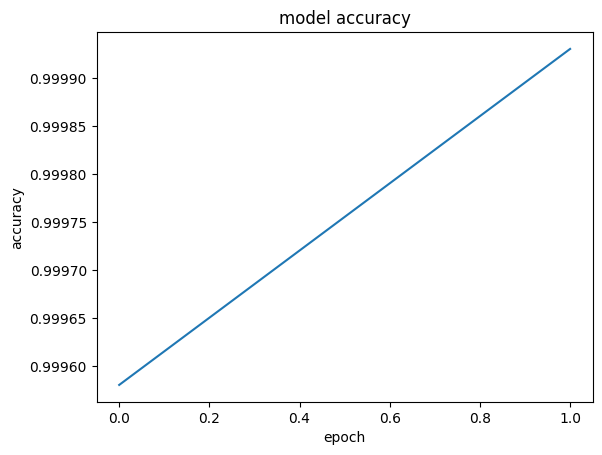

In [27]:
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

# Plot the Model Change Over Epochs

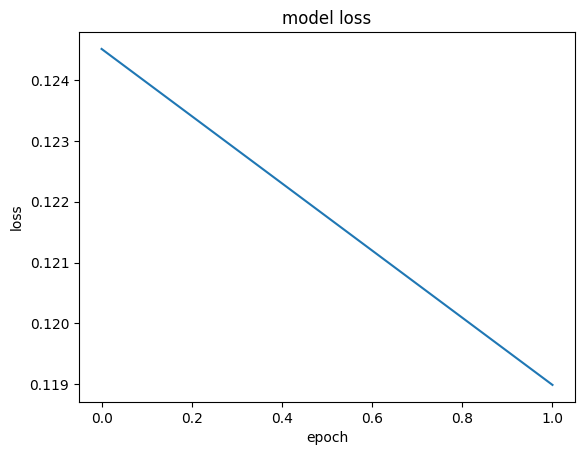

In [28]:
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Predict/Detect Anomalies
Calculate the reconstruction error on new data.

In [30]:
reconstructed = model.predict(windows)

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


In [38]:
print("Reconstructed Shape:", reconstructed.shape)
print("Windows Shape:", windows.shape)

Reconstructed Shape: (572399, 1)
Windows Shape: (572399, 16, 1)


# Calculate Mean Squared Error (MSE)

In [37]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print("MSE Shape:", mse.shape)

MSE Shape: (572399,)


# Set a Threshold for Anomaly Detection Based on the MSE Quantile Values

In [35]:
high1 = np.quantile(np.abs(mse), 0.99999)
# high2 = np.quantile(np.abs(mse), 0.9951)
anomalies_label = [1 if i > high1 else 0 for i in mse]
print("Predicted Anomaly Position:", np.argmax(anomalies_label))
print(
    "Predicted Number of Anomalies:",
    np.count_nonzero(anomalies_label),
    "(depends directly on the quantile range)",
)

Predicted Anomaly Position: 489370
Predicted Number of Anomalies: 6 (depends directly on the quantile range)


# Plot the Seismic Data and Scatterplot of the Predicted Data

[489370 489371 489372 489373 490171 490175]


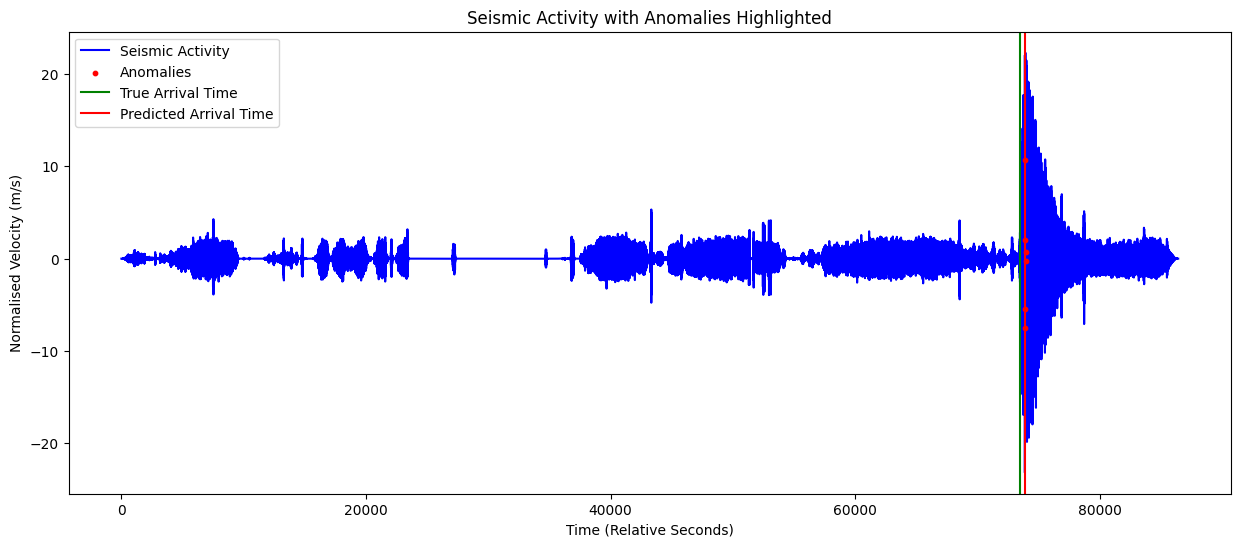

In [40]:
plt.figure(figsize=(15, 6))

plt.plot(
    time["time_rel(sec)"],
    X_standard,
    label="Seismic Activity",
    color="blue",
)


anomaly_indices = np.where(anomalies_label)[0]
print(anomaly_indices)
x_values = X_standard[anomaly_indices + windows_size]

plt.scatter(
    time["time_rel(sec)"][anomaly_indices + windows_size],
    X_standard[anomaly_indices + windows_size],
    color="red",
    label="Anomalies",
    marker="o",
    s=10,
    zorder=2,
)

arrival_line = plt.axvline(x=true_anomaly_time, c="green", label="True Arrival Time")
arrival_line = plt.axvline(
    x=anomaly_indices[0] / 6.625,
    c="red",
    label="Predicted Arrival Time",
)

plt.title("Seismic Activity with Anomalies Highlighted")
plt.xlabel("Time (Relative Seconds)")
plt.ylabel("Normalised Velocity (m/s)")
plt.legend()


plt.show()

# EXTRA: Confusion Matrix
Not really valid...

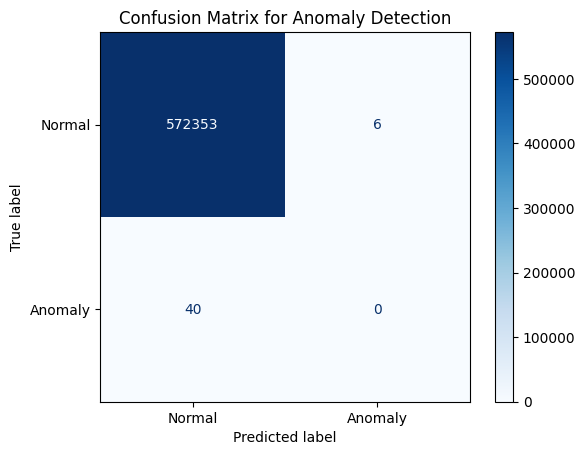

In [41]:
conf_matrix = confusion_matrix(y, anomalies_label)

display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=["Normal", "Anomaly"]
)

display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Extract Model

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 4, 64)          │        12,352 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 8, 32)          │         2,080 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 70,021 (273.52 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 416 (1.62 KB)

 Optimizer params: 46,404 (181.27 KB)

In [44]:
model.save("cnn_old.keras")
model.save("cnn_old.h5")

## Extract Data

In [ ]:
results_df = pd.DataFrame(
    {
        "true_labels": y,
        "predictions": reconstructed.flatten(),
        "mse": mse,
        "anomalies": anomalies_label,
    }
)

results_df.to_csv("./extract/cnn_old_seismic_results.csv", index=False)

anomalies_df = pd.DataFrame(
    {"time_rel(sec)": time_array[windows_size:], "anomalies": anomalies_label}
)

anomalies_df.to_csv("./extract/cnn_old_seismic_anomalies.csv", index=False)